In [3]:
import time
import tensorflow as tf
import numpy as np
import pandas as pd
import preprocess

import cv2
from sklearn.utils import shuffle
from scipy.misc import imread 
import matplotlib.pyplot as plt
%matplotlib inline
import argparse


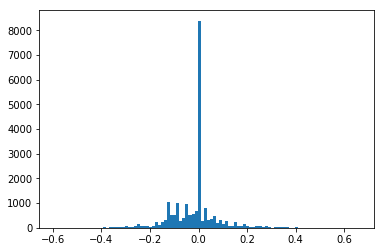

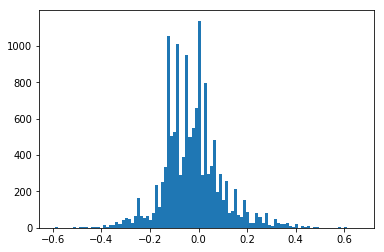

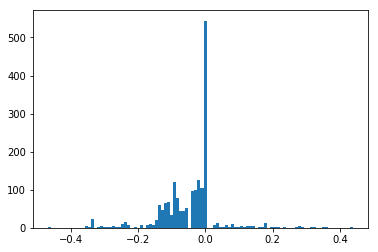

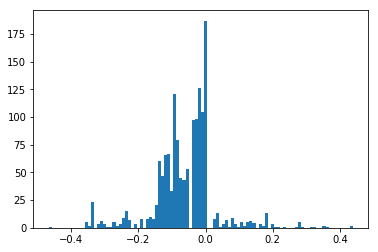

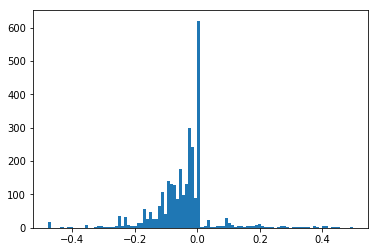

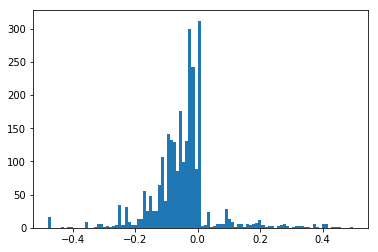

In [4]:
driving_log = pd.read_csv('driving-centered/driving_log.csv')
plt.hist(driving_log.steering, bins=100)
plt.show()
driving_log = pd.concat([driving_log[driving_log.steering==0].sample(frac=0.05),driving_log[driving_log.steering!=0]])
plt.hist(driving_log.steering, bins=100)
plt.show()

driving_log = pd.read_csv('driving-left/driving_log.csv')
plt.hist(driving_log.steering, bins=100)
plt.show()
driving_log = pd.concat([driving_log[driving_log.steering==0].sample(frac=0.25),driving_log[driving_log.steering!=0]])
plt.hist(driving_log.steering, bins=100)
plt.show()

driving_log = pd.read_csv('driving-right/driving_log.csv')
plt.hist(driving_log.steering, bins=100)
plt.show()
driving_log = pd.concat([driving_log[driving_log.steering==0].sample(frac=0.5),driving_log[driving_log.steering!=0]])
plt.hist(driving_log.steering, bins=100)
plt.show()


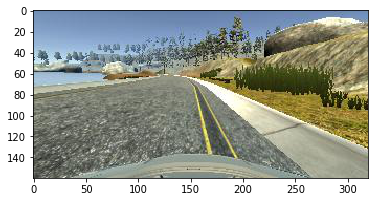

Tensor("Variable_6/read:0", shape=(160, 320, 3), dtype=int8)


In [36]:
image = imread('driving-right/'+driving_log.center.sample().values[0])
plt.imshow(image)
plt.show()

from keras import backend as K
tf_session = K.get_session()
ti = K.variable(value=image, dtype='uint8')
print(ti)

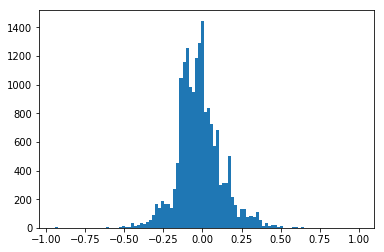

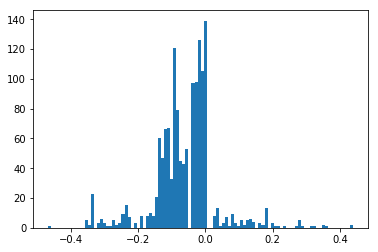

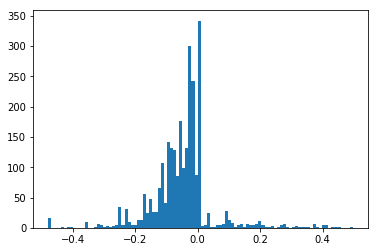

In [20]:
# Train the model
    # History is a record of training loss and metrics
    
parser = argparse.ArgumentParser(description='Train behavioral cloning udacity CarND P3')
parser.add_argument('centerdir', type=str, nargs='?', default='driving-centered', help='Directory name of training data for CENTERED driving')
parser.add_argument('leftdir', type=str,nargs='?', default='driving-left', help='Directory name of training data for driving on the LEFT')
parser.add_argument('rightdir', type=str, nargs='?',default='driving-right', help='Directory name of training data for driving on the RIGHT')
parser.add_argument('model', type=str, nargs='?',default="comma", help='Model (nvidia, comma)')
parser.add_argument('-f', type=str, nargs='?',default="x", help='x (nvidia, comma)')
args = parser.parse_args()
    
center_log = pd.read_csv(args.centerdir+'/driving_log.csv')
left_log   = pd.read_csv(args.leftdir+'/driving_log.csv')
right_log  = pd.read_csv(args.rightdir+'/driving_log.csv')
for i in ['left', 'right', 'center']:
    center_log[i] = args.centerdir + center_log[i].str.strip()
    left_log[i]   = args.leftdir   + left_log[i].str.strip()
    right_log[i]  = args.rightdir  + right_log[i].str.strip()

def keep_only(log, keep):
    return pd.concat([log[log.steering==0].sample(frac=keep),log[log.steering!=0]])

    
# get rid of 85% of zero steering
center_log = keep_only(center_log, 0.05)
left_log   = keep_only(left_log, 0.15)
right_log  = keep_only(right_log, 0.55)
    
plt.hist(center_log.steering, bins=100)
plt.show()

plt.hist(left_log.steering, bins=100)
plt.show()

plt.hist(right_log.steering, bins=100)
plt.show()


In [2]:


(sizex,sizey) = preprocess.size()

XBS = 2
BS = 1

def generator(log):
    
    shown = False
    
    while True:
        log = shuffle(log)

        
        for centerfiles, rightfiles, leftfiles, steerings in \
            zip(log['center'].values.reshape(-1,BS), 
                log['right'].values.reshape(-1,BS ), 
                log['left'].values.reshape(-1,BS ), 
                log['steering'].values.reshape(-1,BS )):
                
            images              = np.zeros((BS*XBS, sizey, sizex, 3), dtype=np.uint8)
            augmented_steerings = np.zeros((BS*XBS), dtype=np.float32)

            for i, (centerfile, rightfile, leftfile, steering) in enumerate(zip(centerfiles, rightfiles, leftfiles, steerings)):
                centerimage         = preprocess.preprocess(imread('antor-data/' + centerfile.strip()))
                rightimage          = preprocess.preprocess(imread('antor-data/' + rightfile.strip()))
                leftimage           = preprocess.preprocess(imread('antor-data/' + leftfile.strip()))

                
                if shown==False:
                    print(imread('antor-data/' + centerfile.strip()).shape)
                    plt.imshow(cv2.cvtColor(centerimage, cv2.COLOR_YCrCb2RGB))
                    plt.show()
                    plt.imshow(cv2.cvtColor(rightimage, cv2.COLOR_YCrCb2RGB))
                    plt.show()
                    plt.imshow(cv2.cvtColor(leftimage, cv2.COLOR_YCrCb2RGB))
                    plt.show()

                    shown=True

                    
                images[i]                   = centerimage
                augmented_steerings[i]      = steering
                images[i+BS]                = cv2.flip(centerimage, flipCode = 1)
                augmented_steerings[i+BS]   = -steering

                '''
                steering_correction = 0.17

                if ((steering - steering_correction) > -1.):
                    images[i+BS]                = rightimage
                    augmented_steerings[i+BS]   = steering - steering_correction
                else:
                    images[i+BS]                = centerimage
                    images[i+BS*2]              = steering

                if ((steering + steering_correction) < 1.):
                    images[i+BS*2]              = leftimage
                    augmented_steerings[i+BS*2] = steering + steering_correction
                else:
                    images[i+BS*2]              = centerimage
                    augmented_steerings[i+BS*2] = steering 
                    '''
            yield (images, augmented_steerings)



![Nvidia CNN architecture](http s://devblogs.nvidia.com/parallelforall/wp-content/uploads/2016/08/cnn-architecture-624x890.png)

In [ ]:

from model import get_model

model = get_model('comma')


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 160, 320, 3)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 40, 80, 16)    3088        lambda_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 40, 80, 16)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 20, 40, 32)    12832       activation_1[0][0]               
___________________________________________________________________________________________

Using TensorFlow backend.


Samples in train set: 4473
Epoch 1/4
(160, 320, 3)


/home/antor/CarND-p3/preprocess.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  image = image[leny * .35 : leny *.85 ,:]


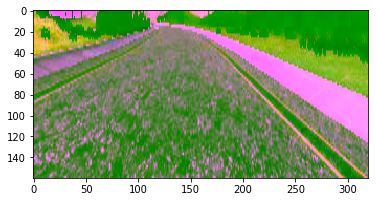

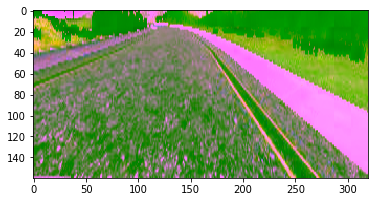

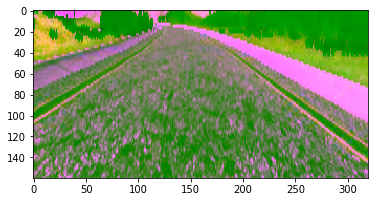

8944/8946 [============================>.] - ETA: 0s - loss: 2.7239 - mean_squared_error: 2.7239    

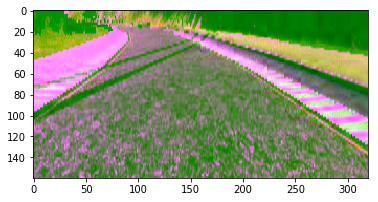

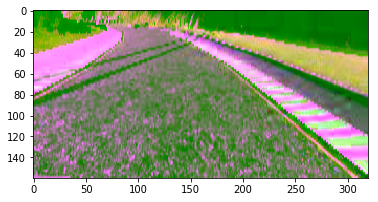

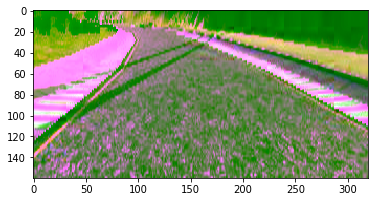

8946/8946 [==============================] - 42s - loss: 2.7233 - mean_squared_error: 2.7233 - val_loss: 0.0163 - val_mean_squared_error: 0.0163
Epoch 2/4
8946/8946 [==============================] - 40s - loss: 1639.4973 - mean_squared_error: 1639.4973 - val_loss: 0.2196 - val_mean_squared_error: 0.2196

In [ ]:
# Train the model
# History is a record of training loss and metrics
driving_log = pd.read_csv('antor-data/driving_log.csv')

from sklearn.model_selection import train_test_split

train_log, validate_log = train_test_split(driving_log, test_size=0.20)
print("Samples in train set:", train_log.shape[0])

history = model.fit_generator(generator(train_log), 
            nb_epoch=4, 
            samples_per_epoch = train_log.shape[0]*XBS,
            validation_data = generator(validate_log),
            nb_val_samples = validate_log.shape[0]*XBS)




In [ ]:
from keras.models import model_from_json
#from keras.models import save_weights

name = 'comma'

with open(name + ".json", "w") as file:
    file.write(model.to_json())

model.save_weights(name + '.h5')

